# Titanic Classification

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix

In [40]:
df = pd.read_csv("/Volumes/Personal/DS_Code Alpha/Shipwreck-Survival-Pred/titanic.csv")

In [41]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
# Drop columns that are not useful for prediction
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Handle missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['Embarked'] = label_encoder.fit_transform(df['Embarked'])

# Visualizing data distributions

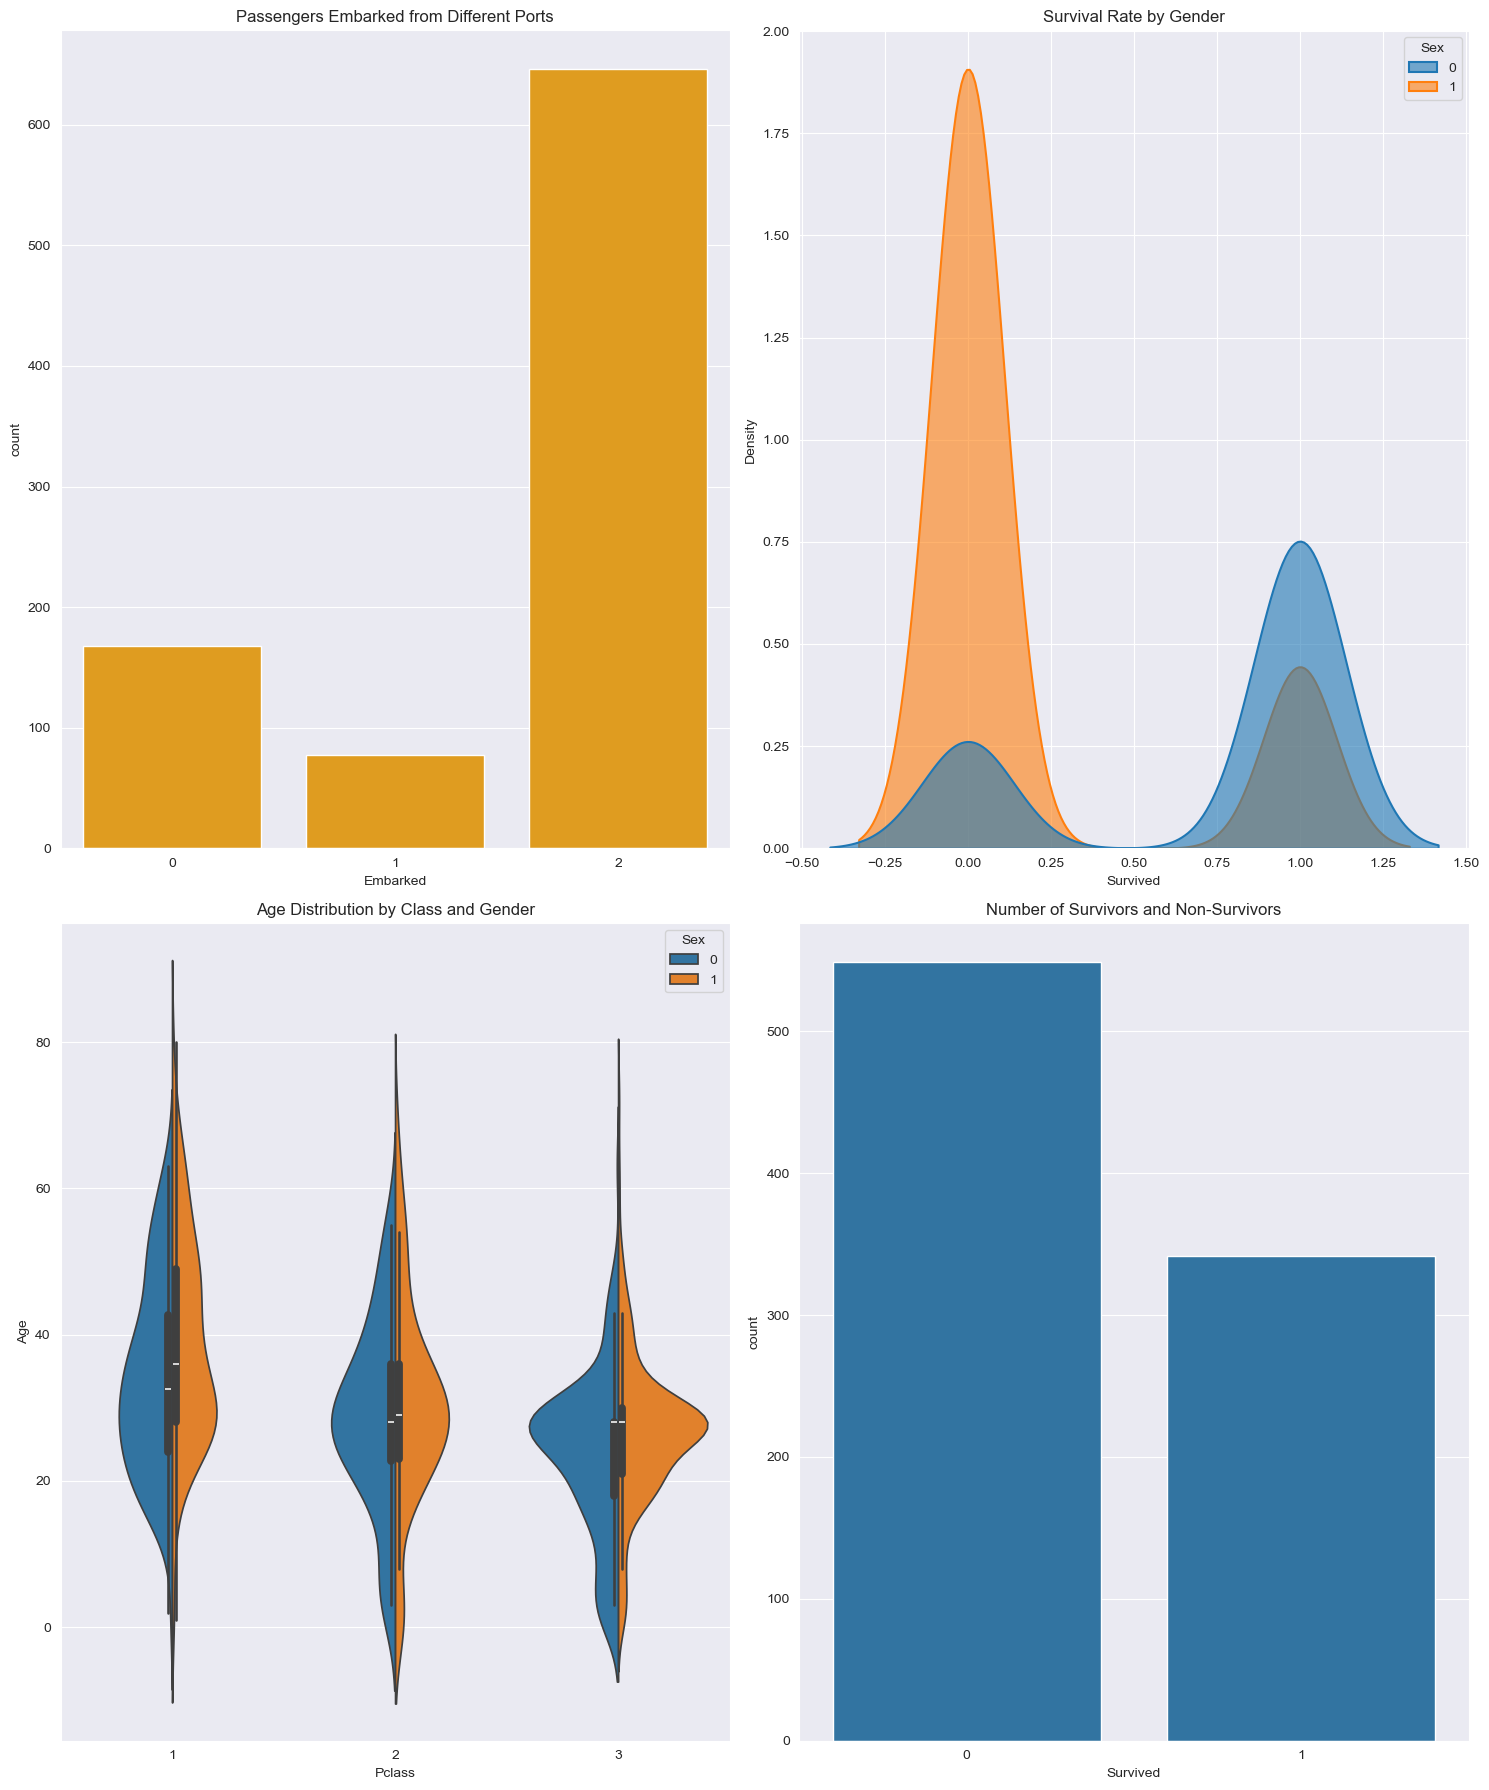

In [43]:

sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 18))

sns.countplot(x='Embarked', data=df, ax=axes[0, 0], color='orange')
axes[0, 0].set_title('Passengers Embarked from Different Ports')

sns.kdeplot(data=df, x="Survived", hue="Sex", fill=True, alpha=0.6, linewidth=1.5, ax=axes[0, 1])
axes[0, 1].set_title('Survival Rate by Gender')

sns.violinplot(x='Pclass', y='Age', hue='Sex', data=df, split=True, ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution by Class and Gender')

sns.countplot(x='Survived', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Number of Survivors and Non-Survivors')

plt.tight_layout()
plt.show()

# Correlation heatmap

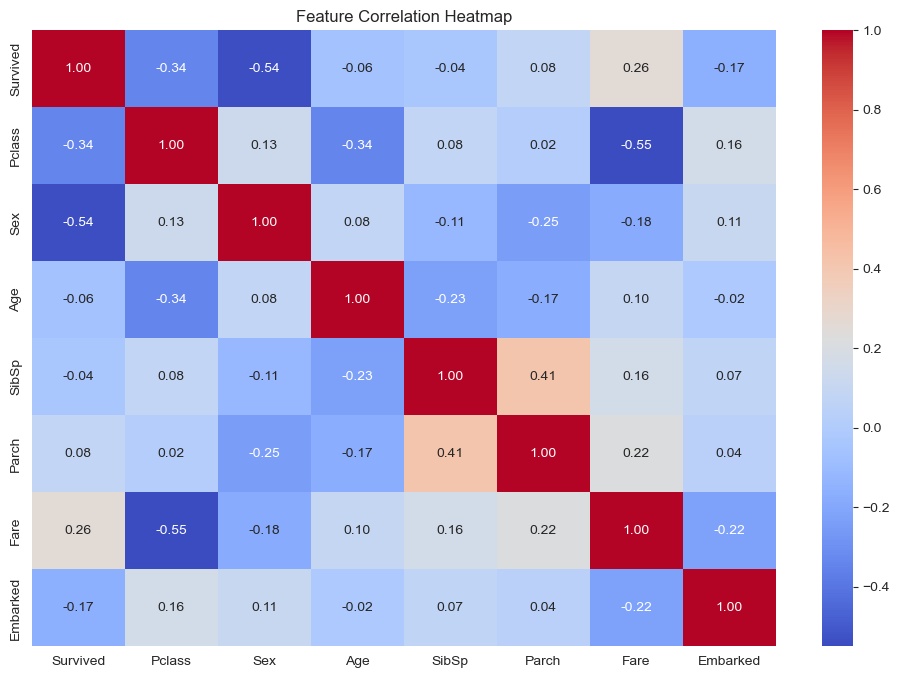

In [44]:

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [45]:

# Feature selection using statistical methods
X = df.drop("Survived", axis=1)
y = df["Survived"]


In [46]:
# Chi-Squared Test
chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(X, y)
chi_scores = pd.Series(chi_selector.scores_, index=X.columns).sort_values(ascending=False)
print("Chi-Squared Scores:")
print(chi_scores)

Chi-Squared Scores:
Fare        4518.319091
Sex           92.702447
Pclass        30.873699
Age           21.649163
Embarked      10.202525
Parch         10.097499
SibSp          2.581865
dtype: float64


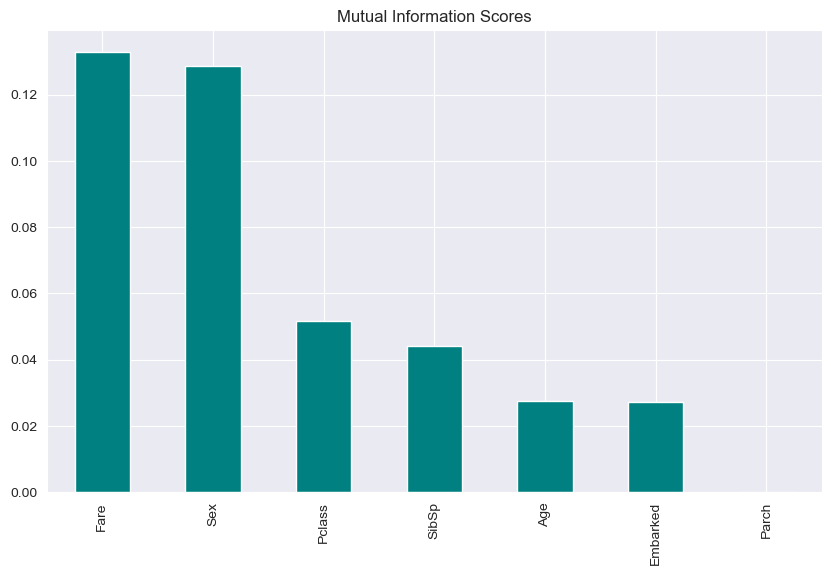

In [47]:
# Mutual Information Scores
mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar', color='teal')
plt.title("Mutual Information Scores")
plt.show()

In [ ]:

# Standardizing numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy']
}


In [ ]:
#  Random Forest model training with hyperparameter tuning
rf = RandomForestClassifier(random_state=26)
grid_search = GridSearchCV(rf, param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)


rf_best = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")


y_pred = rf_best.predict(X_test)

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 300}
Best Cross-Validation Score: 0.8412921348314607


In [50]:

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



# Confusion matrix

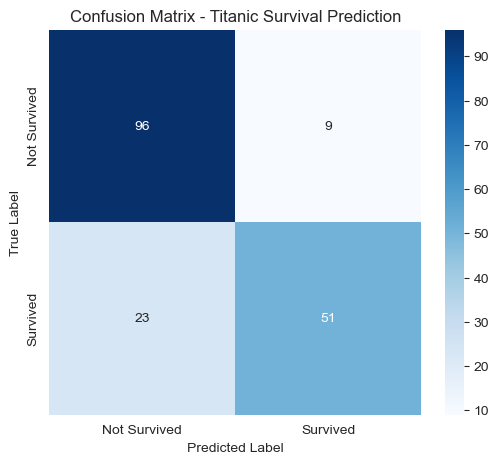

In [51]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Titanic Survival Prediction")
plt.show()

In [ ]:
# Predicting survival 
def predict_survival(sample):
    sample_scaled = pd.DataFrame(scaler.transform(sample), columns=X.columns)
    prediction = rf_best.predict(sample_scaled)
    return "YES" if prediction[0] == 1 else "NO"


sample_one = pd.DataFrame([{
    'Pclass': 1,
    'Sex': 0,
    'Age': 25,
    'SibSp': 1,
    'Parch': 1,
    'Fare': 80.0,
    'Embarked': 0,
}])
print("Predicted Outcome:", predict_survival(sample_one))


Predicted Outcome: YES


In [53]:
sample_two = pd.DataFrame([{
    'Pclass': 3,
    'Sex': 1,
    'Age': 35,
    'SibSp': 0,
    'Parch': 0,
    'Fare': 5.0,
    'Embarked': 2,
}])
print("Predicted Outcome:", predict_survival(sample_two))

Predicted Outcome: NO
